###### source
* https://gist.github.com/cdipaolo/9dd6794a4f0a2889ef60a5effa419093

In [1]:
import numpy as np
from scipy import special

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def t(X, dof=3.5, iter=200, eps=1e-6):
    '''t
    Estimates the mean and covariance of the dataset
    X (rows are datapoints) assuming they come from a
    student t likelihood with no priors and dof degrees
    of freedom using the EM algorithm.
    Implementation based on the algorithm detailed in Murphy
    Section 11.4.5 (page 362).
    :param X: dataset
    :type  X: np.array[n,d]
    :param dof: degrees of freedom for likelihood
    :type  dof: float > 2
    :param iter: maximum EM iterations
    :type  iter: int
    :param eps: tolerance for EM convergence
    :type  eps: float
    :return: estimated covariance, estimated mean, list of
             objectives at each iteration.
    :rtype: np.array[d,d], np.array[d], list[float]
    '''
    # initialize parameters
    D = X.shape[1]
    N = X.shape[0]
    cov = np.cov(X,rowvar=False)
    mean = X.mean(axis=0)
    mu = X - mean[None,:]
    delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
    z = (dof + D) / (dof + delta)
    obj = [
        -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 \
        -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2
    ]

    # iterate
    for i in range(iter):
        # M step
        mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum()
        mu = X - mean.squeeze()[None,:]
        cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N

        # E step
        delta = (mu * np.linalg.solve(cov,mu.T).T).sum(axis=1)
        delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
        z = (dof + D) / (dof + delta)

        # store objective
        obj.append(
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 \
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2
        )   
        
        if np.abs(obj[-1] - obj[-2]) < eps:
            break
    return cov, mean.squeeze(), obj

##### Generating t-Distribution random sample

In [5]:
from multivariate_util import *

In [6]:
mu_  = np.array([1.5, 1], dtype=np.float32)
cov_ = np.array([[1, 0], [0, 1]], dtype=np.float32)

In [7]:
X = multivariate_t_rvs(mu_, cov_, 10, 75)

##### Estimating the parameters

In [8]:
result = t(X)

In [9]:
print 'mu: %s' % result[1]
print 'cov: %s' % result[0]

mu: [ 1.52471215  1.02431145]
cov: [[ 0.95905663 -0.09955311]
 [-0.09955311  0.81183085]]


##### Plotting log-likelihood

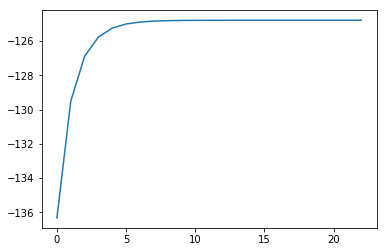

In [10]:
plt.plot(range(len(result[2])), result[2])

##### Plotting contour

In [11]:
t_func = multivariate_t(result[1], result[0], 3.5)

x, y = np.mgrid[-4:4:.1, -4:4:.1]
xy = np.column_stack([x.ravel(), y.ravel()])

In [12]:
z = []
for _ in xy:
    z.append(t_func.pdf(_))
z = np.reshape(z, x.shape)

In [ ]:
X = multivariate_t_rvs(m=mu, S=cov, df=df, n=75)

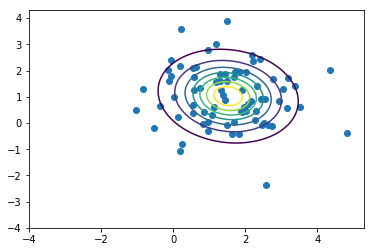

In [13]:
plt.scatter(X.T[0], X.T[1])
plt.contour(x, y, z)